In [2]:
import os 
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import matplotlib.pyplot as plt

from utils.utils import *

from utils.split_condition import split_conditions
from nsddatapaper_rsa.utils.nsd_get_data import get_conditions, get_betas 
from sklearn.metrics import r2_score

#### Ben' spseudo code 
%First, calcualte the best fit a model could ever do.

rss=sum((betas_train - betas_test).^2);

%Next, calculate the residual if we explained NO variance

variance=sum((betas_test-mean(betas_test)).^2);

ve_test=1-rss/variance


In [11]:
"""
Compute the noise ceilling using rescale for each voxel
The one we (currently) use 
"""
#best_variance = np.zeros((len(subj_list), len(rois.keys())))
for i, subj in enumerate(subj_list):

    train_path = os.path.join(betas_dir, f'{subj}_betas_list_nativesurface_train.npy')
    test_path = os.path.join(betas_dir, f'{subj}_betas_list_nativesurface_test.npy')
    betas_mask = np.load(os.path.join(betas_dir, f'{subj}_betas_list_nativesurface_train_test_mask.npy'), allow_pickle=True)
    if subj == 'subj06' or subj == 'subj08':
        roi_mask = os.path.join(mask_dir, subj, f'short.reduced.nans.{subj}.testrois.npy')
    else:
        roi_mask = os.path.join(mask_dir, subj, f'short.reduced.{subj}.testrois.npy')
    betas_train = np.load(train_path, allow_pickle=True)
    betas_test = np.load(test_path, allow_pickle=True)
    mask = np.load(roi_mask, allow_pickle=True)
    betas_train = betas_train[:,betas_mask]
    noise_ceilling_all_vox = np.zeros(betas_train.shape[0])
    print(noise_ceilling_all_vox.shape)
    noise_ceilling_file = os.path.join(noise_dir, f'{subj}_noise_ceilling_all_vox.npy')
    if os.path.exists(noise_ceilling_file):
        continue
    

    for row in range(betas_train.shape[0]):  
        if row % 1000 == 0: 
            print(f'------- FINDING NOISE CEILLING FOR ROW {row}') 
         
        current_row = np.array([betas_train[row]])
        

        new_row = rescale(current_row, betas_test[row])
   
        if row == 0:
            print(new_row)

        print(new_row.shape)
        print(betas_test[row].shape)
        
        rss = np.sum((new_row - betas_test[row])**2)  # make this  the same as the variance; new row is some flag value 
        # so bound the rescale at 0 
        # if the result is negative, rss == variance 
        # otherwise rss is the same 
     #   print("------RSS----")
     #   print(rss.shape)
    

        variance = np.sum((betas_test[row] - np.mean(betas_test[row]))**2)
     #   ve_test = 1-rss/variance  
     #   print("------VAR----")
       # print(variance.shape)
        ve_voxels = 1 - rss / variance    # noise ceilling of all voxels in current roi 
        if row % 1000 == 0:
            print(f'-------  NOISE CEILLING FOR ROW {row} is {ve_voxels}') 
        noise_ceilling_all_vox[row] = ve_voxels

    np.save(noise_ceilling_file, noise_ceilling_all_vox)
    
        
  
      #  best_variance[i, j] = ve_test
#print(best_variance)     

(33797,)
------- FINDING NOISE CEILLING FOR ROW 0
(0.34109609782353323, array([0.33601608, 0.01412043]))


AttributeError: 'tuple' object has no attribute 'shape'

In [ ]:
"""
Compute the noise ceilling using rescale for each voxel
If scale is below 0: do not rescale 
"""
#best_variance = np.zeros((len(subj_list), len(rois.keys())))
for i, subj in enumerate(subj_list):

    train_path = os.path.join(betas_dir, f'{subj}_betas_list_nativesurface_train.npy')
    test_path = os.path.join(betas_dir, f'{subj}_betas_list_nativesurface_test.npy')
    betas_mask = np.load(os.path.join(betas_dir, f'{subj}_betas_list_nativesurface_train_test_mask.npy'), allow_pickle=True)
    if subj == 'subj06' or subj == 'subj08':
        roi_mask = os.path.join(mask_dir, subj, f'short.reduced.nans.{subj}.testrois.npy')
    else:
        roi_mask = os.path.join(mask_dir, subj, f'short.reduced.{subj}.testrois.npy')
    betas_train = np.load(train_path, allow_pickle=True)
    betas_test = np.load(test_path, allow_pickle=True)
    mask = np.load(roi_mask, allow_pickle=True)
    betas_train = betas_train[:,betas_mask]
    noise_ceilling_all_vox = np.zeros(betas_train.shape[0])
    print(noise_ceilling_all_vox.shape)
    noise_ceilling_file = os.path.join(noise_dir, f'{subj}_noise_ceilling_all_vox_not_neg.npy')
    if os.path.exists(noise_ceilling_file):
        continue
    

    for row in range(betas_train.shape[0]):  
        if row % 10000 == 0: 
            print(f'------- FINDING NOISE CEILLING FOR ROW {row}') 
         
        current_row = np.array([betas_train[row]])
        

        new_row, scale = rescale(current_row, betas_test[row])
   
        
         
        if scale[0] >= 0: 
            rss = np.sum((new_row - betas_test[row])**2)
            
        else:
             
            rss = np.sum((betas_test[row] - np.mean(betas_test[row]))**2)# make this  the same as the variance; new row is some flag value 
        # so bound the rescale at 0 
        # if the result is negative, rss == variance 
        # otherwise rss is the same 
     #   print("------RSS----")
     #   print(rss.shape)
    

        variance = np.sum((betas_test[row] - np.mean(betas_test[row]))**2)
     #   ve_test = 1-rss/variance  
     #   print("------VAR----")
       # print(variance.shape)
        ve_voxels = 1 - rss / variance    # noise ceilling of all voxels in current roi 
        if row % 10000 == 0:
            print(f'-------  NOISE CEILLING FOR ROW {row} is {ve_voxels}') 
        noise_ceilling_all_vox[row] = ve_voxels

    np.save(noise_ceilling_file, noise_ceilling_all_vox)
    
        
  
      #  best_variance[i, j] = ve_test
#print(best_variance)     

In [ ]:
"""
Compute the R2 correlation between each voxel
"""

#best_variance = np.zeros((len(subj_list), len(rois.keys())))
for i, subj in enumerate(subj_list):

    train_path = os.path.join(betas_dir, f'{subj}_betas_list_nativesurface_train.npy')
    test_path = os.path.join(betas_dir, f'{subj}_betas_list_nativesurface_test.npy')
    betas_mask = np.load(os.path.join(betas_dir, f'{subj}_betas_list_nativesurface_train_test_mask.npy'), allow_pickle=True)
    if subj == 'subj06' or subj == 'subj08':
        roi_mask = os.path.join(mask_dir, subj, f'short.reduced.nans.{subj}.testrois.npy')
    else:
        roi_mask = os.path.join(mask_dir, subj, f'short.reduced.{subj}.testrois.npy')
    print(roi_mask)
    betas_train = np.load(train_path, allow_pickle=True)
    betas_test = np.load(test_path, allow_pickle=True)
    mask = np.load(roi_mask, allow_pickle=True)
    betas_train = betas_train[:,betas_mask]
    noise_ceilling_all_vox = np.zeros(betas_train.shape[0])
    print(noise_ceilling_all_vox.shape)
    noise_ceilling_file = os.path.join(noise_dir, f'{subj}_R2_all_vox.npy')
    if os.path.exists(noise_ceilling_file):
        continue
    

    for row in range(betas_train.shape[0]):  
        if row % 1000 == 0: 
            print(f'------- FINDING NOISE CEILLING FOR ROW {row}') 
         
        current_row = np.array([betas_train[row]])
        

        new_row = rescale(current_row, betas_test[row])
   
        if row == 0:
            print(new_row)
         
        
        rss = np.sum((new_row - betas_test[row])**2)  # make this  the same as the variance; new row is some flag value 
        # so bound the rescale at 0 
        # if the result is negative, rss == variance 
        # otherwise rss is the same 
     #   print("------RSS----")
     #   print(rss.shape)
    

        variance = np.sum((betas_test[row] - np.mean(betas_test[row]))**2)
     #   ve_test = 1-rss/variance  
     #   print("------VAR----")
       # print(variance.shape)
        R2_voxels = rss / variance    # noise ceilling of all voxels in current roi 
        if row % 1000 == 0:
            print(f'-------  R2 FOR ROW {row} is {R2_voxels}') 
        noise_ceilling_all_vox[row] = R2_voxels

    np.save(noise_ceilling_file, noise_ceilling_all_vox)
    
        
  
      #  best_variance[i, j] = ve_test
#print(best_variance)      

In [128]:
"""
the code is currently used to get the best roi on the cortical surface  ==== I should parameterize it 
"""
models_subs = {}
models = ['best_roi', 'oself']
columns = ["x0", "y0", "sigma", "slope", "intercept", "test_var_explained", "var_explained", "mds_ecc", "mds_ang", "roi", "fit_with"]
columns = ["x0", "y0", "sigma", "slope", "intercept", "test_var_explained", "var_explained", "mds_ecc", "mds_ang", "roi", "best_roi"]
model_study = 'woself'
model_study = 'best_roi'
mode = "train"
rotated = True

#cos_sin = get_prefered_xy(subj_list) # save that and open it matlab 
#print(cos_sin)


for i, sub in enumerate(subj_list):
    models_subs[sub] = {}
    noise_ceilling_file = os.path.join(noise_dir, f'{sub}_noise_ceilling_all_vox.npy')
    R2_file = os.path.join(noise_dir, f'{sub}_R2_all_vox.npy')
    noise_ceilling = np.load(noise_ceilling_file, allow_pickle=True)
    R2 = np.load(R2_file, allow_pickle=True)
    for m in models:
        if m == 'best_roi':
            m_file = os.path.join(models_dir, f'best_fits_{m}_{sub}_{mode}.npy')
        else: 
            m_file = os.path.join(models_dir, f'best_fits_{m}_{sub}_{mode}.npy')
        models_subs[sub][m] = pd.DataFrame(np.load(m_file, allow_pickle=True), columns=columns)
        models_subs[sub][m][columns[:-2]] = models_subs[sub][m][columns[:-2]].astype(np.float32)
        models_subs[sub][m]['noise_ceilling'] = noise_ceilling
        models_subs[sub][m]['R2'] = R2
        models_subs[sub][m]['voxel_performance'] = models_subs[sub][m]["test_var_explained"] / models_subs[sub][m]['noise_ceilling']
#models_subs
     #   np.save(m_file, models_subs[sub][m])

In [12]:
def rescale(train, test):
    """
    Input 
    -------
    train: 1D array of length n, to rescale
    test : 1D array of length n, target to rescale to

    Output 
    --------
    new_train: 1D array of length n, rescale train array
    """
    if len(train.shape) == 1:
        train = np.array([train]) # add a dimension for concat
   # print(train.shape)
    train_ones = np.concatenate((train, np.ones((train.shape[0], train.shape[1])))).T
    scale = np.linalg.pinv(train_ones) @ test.T 

    new_train = train_ones @ scale  
    return new_train.T.squeeze(), scale

## NOISE CEILLING FOR VARIANCE

In [6]:
best_variance_df = pd.DataFrame(best_variance, columns=rois.keys(), index=subj_list)
best_variance_df[0]

NameError: name 'best_variance' is not defined

In [8]:
path_noise_ceilling = os.path.join(results_dir, 'noise_ceilling_perROI.npy')
#np.save(path_noise_ceilling, best_variance)

In [10]:
pd.DataFrame(np.load(path_noise_ceilling), index=subj_list, columns=list(rois.keys()))

,V1,V2,V3,hV4,VO-1,VO-2,PHC-1,PHC-2,LO-1,LO-2,TO-1,TO-2
subj01,0.160046,0.149248,0.122393,0.090569,0.090560,0.085919,0.081755,0.089556,0.064588,0.073248,0.186000,0.143061
subj02,0.207016,0.130534,0.136162,0.151621,0.120854,0.101976,0.096441,0.107260,0.092186,0.095624,0.154774,0.118792
subj03,0.092095,0.074723,0.051920,0.046549,0.065593,0.060212,0.063963,0.094322,0.030097,0.043181,0.122306,0.075306
subj04,0.100047,0.101491,0.052764,0.045423,0.072444,0.062329,0.071130,0.078930,0.022944,0.053599,0.058696,0.129924
subj05,0.121370,0.112521,0.082080,0.092580,0.111688,0.094420,0.119259,0.152963,0.064147,0.114321,0.131372,0.158343
subj06,0.104087,0.094338,0.062464,0.051322,0.067789,0.079620,0.085503,0.101149,0.027562,0.072529,0.099844,0.047400
subj07,0.053951,0.048584,0.043284,0.035758,0.059237,0.036344,0.022674,0.033086,0.021040,0.064491,0.068336,0.087694
subj08,0.062130,0.059103,0.039567,0.051410,0.045503,0.038874,0.045419,0.045788,0.024235,0.034186,0.036418,0.033960


In [121]:
VE_per_voxel = pd.DataFrame( index=subj_list, columns=list(rois.keys()) )
                                    
for i, subj in enumerate(subj_list):
    if subj == 'subj06' or subj == 'subj08':
        roi_mask = os.path.join(mask_dir, subj, f'short.reduced.nans.{subj}.testrois.npy')
    else:
        roi_mask = os.path.join(mask_dir, subj, f'short.reduced.{subj}.testrois.npy')
    mask = np.load(roi_mask).astype(int)
    VE_per_voxel.iloc[i] = models_subs[subj]['best_roi']['test_var_explained'].groupby(mask).mean()
noise_ceilling_per_voxel

,V1,V2,V3,hV4,VO-1,VO-2,PHC-1,PHC-2,LO-1,LO-2,TO-1,TO-2
subj01,0.160141,0.149004,0.121824,0.089139,0.089698,0.085216,0.081076,0.089601,0.063419,0.072624,0.186105,0.143335
subj02,0.207029,0.13017,0.135489,0.151028,0.120554,0.101368,0.095674,0.106872,0.091456,0.095145,0.154912,0.118954
subj03,0.092003,0.074787,0.051863,0.046266,0.065372,0.059983,0.064044,0.094903,0.029901,0.042929,0.122582,0.075624
subj04,0.099694,0.101062,0.052432,0.044738,0.071621,0.061387,0.069915,0.077274,0.022318,0.052382,0.057126,0.132277
subj05,0.121639,0.113051,0.08204,0.092427,0.110654,0.093609,0.118989,0.153154,0.06393,0.114499,0.131577,0.159661
subj06,0.103976,0.094369,0.062552,0.051291,0.06783,0.079387,0.085221,0.100913,0.027471,0.072598,0.100141,0.047992
subj07,0.053931,0.048471,0.043206,0.035782,0.059047,0.036257,0.02264,0.033077,0.020985,0.064429,0.068251,0.087659
subj08,0.061587,0.058725,0.039229,0.051098,0.045447,0.038712,0.045437,0.045775,0.024054,0.034068,0.036513,0.033981


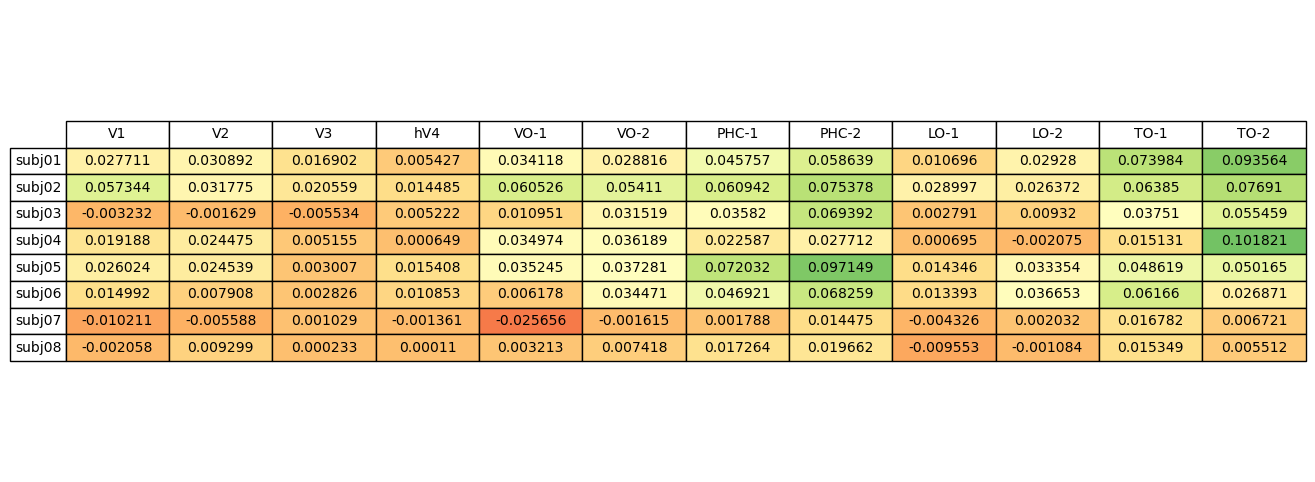

In [122]:
df = VE_per_voxel.apply(pd.to_numeric)
norm = plt.Normalize(df.values.min()-0.05, df.values.max()+0.05)

# Create a custom colormap
cmap = plt.get_cmap('RdYlGn')

# Create a figure and a single subplot
fig, ax = plt.subplots(figsize=(10, 6))

# Hide the axes
ax.axis('tight')
ax.axis('off')

# Create a table with colored cells
cell_colors = cmap(norm(df.values))

# Add table to the axes
table = ax.table(cellText=df.values.round(6),
                 rowLabels=df.index,
                 colLabels=df.columns,
                 cellColours=cell_colors,
                 cellLoc='center',
                 loc='center')

# Customize the table appearance
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.6, 1.6)
plt.savefig('VE_best_roi.png', bbox_inches='tight')
# Display the plotSS
plt.show()

In [82]:
noise_ceilling_per_voxel = pd.DataFrame( index=subj_list, columns=list(rois.keys()) )
                                    
for i, subj in enumerate(subj_list):
    if subj == 'subj06' or subj == 'subj08':
        roi_mask = os.path.join(mask_dir, subj, f'short.reduced.nans.{subj}.testrois.npy')
    else:
        roi_mask = os.path.join(mask_dir, subj, f'short.reduced.{subj}.testrois.npy')
    mask = np.load(roi_mask).astype(int)
    noise_ceilling_per_voxel.iloc[i] = models_subs[subj]['best_roi']['noise_ceilling'].groupby(mask).mean()
noise_ceilling_per_voxel

,V1,V2,V3,hV4,VO-1,VO-2,PHC-1,PHC-2,LO-1,LO-2,TO-1,TO-2
subj01,0.160141,0.149004,0.121824,0.089139,0.089698,0.085216,0.081076,0.089601,0.063419,0.072624,0.186105,0.143335
subj02,0.207029,0.13017,0.135489,0.151028,0.120554,0.101368,0.095674,0.106872,0.091456,0.095145,0.154912,0.118954
subj03,0.092003,0.074787,0.051863,0.046266,0.065372,0.059983,0.064044,0.094903,0.029901,0.042929,0.122582,0.075624
subj04,0.099694,0.101062,0.052432,0.044738,0.071621,0.061387,0.069915,0.077274,0.022318,0.052382,0.057126,0.132277
subj05,0.121639,0.113051,0.08204,0.092427,0.110654,0.093609,0.118989,0.153154,0.06393,0.114499,0.131577,0.159661
subj06,0.103976,0.094369,0.062552,0.051291,0.06783,0.079387,0.085221,0.100913,0.027471,0.072598,0.100141,0.047992
subj07,0.053931,0.048471,0.043206,0.035782,0.059047,0.036257,0.02264,0.033077,0.020985,0.064429,0.068251,0.087659
subj08,0.061587,0.058725,0.039229,0.051098,0.045447,0.038712,0.045437,0.045775,0.024054,0.034068,0.036513,0.033981


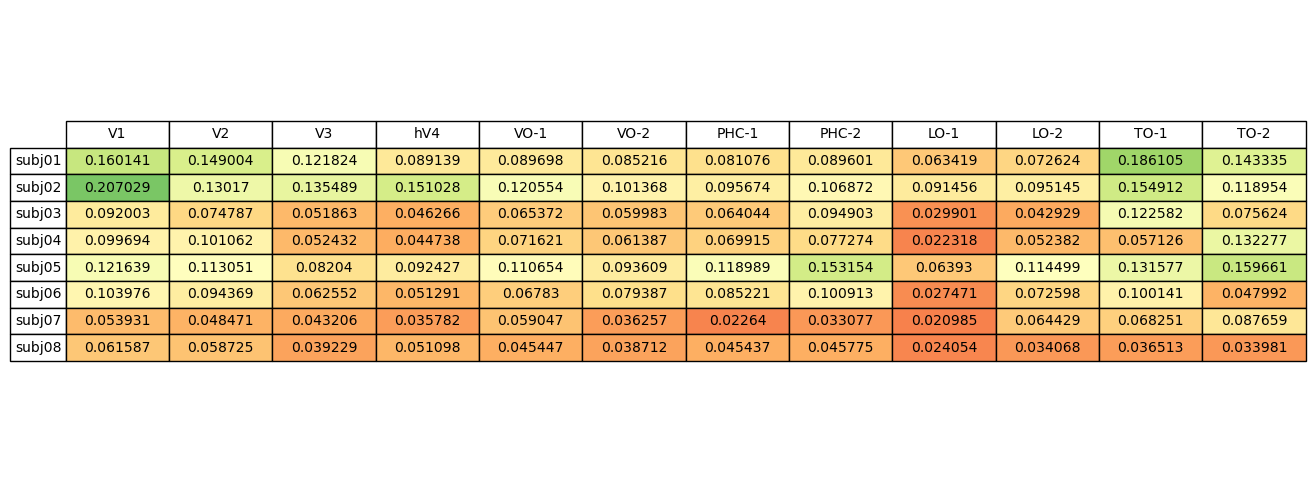

In [126]:
df = noise_ceilling_per_voxel.apply(pd.to_numeric)
norm = plt.Normalize(df.values.min()-0.08, df.values.max()+0.08)

# Create a custom colormap
cmap = plt.get_cmap('RdYlGn')

# Create a figure and a single subplot
fig, ax = plt.subplots(figsize=(10, 6))

# Hide the axes
ax.axis('tight')
ax.axis('off')

# Create a table with colored cells
cell_colors = cmap(norm(df.values))

# Add table to the axes
table = ax.table(cellText=df.values.round(6),
                 rowLabels=df.index,
                 colLabels=df.columns,
                 cellColours=cell_colors,
                 cellLoc='center',
                 loc='center')

# Customize the table appearance
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.6, 1.6)
plt.savefig('noise_ceilling_best_roi.png', bbox_inches='tight')
# Display the plotSS
plt.show()

In [85]:
voxel_perf_per_voxel = pd.DataFrame( index=subj_list, columns=list(rois.keys()) )
                                    
for i, subj in enumerate(subj_list):
    if subj == 'subj06' or subj == 'subj08':
        roi_mask = os.path.join(mask_dir, subj, f'short.reduced.nans.{subj}.testrois.npy')
    else:
        roi_mask = os.path.join(mask_dir, subj, f'short.reduced.{subj}.testrois.npy')
    mask = np.load(roi_mask).astype(int)
    voxel_perf_per_voxel.iloc[i] = models_subs[subj]['best_roi']['voxel_performance'].groupby(mask).median()
voxel_perf_per_voxel

,V1,V2,V3,hV4,VO-1,VO-2,PHC-1,PHC-2,LO-1,LO-2,TO-1,TO-2
subj01,0.151741,0.150579,0.101542,0.030396,0.322279,0.366542,0.616868,0.648627,0.059659,0.221925,0.435081,0.652332
subj02,0.137578,0.110969,0.107965,0.068051,0.460134,0.588035,0.724519,0.82972,0.264172,0.289377,0.397471,0.743818
subj03,-0.084067,-0.103247,-0.117294,-0.002923,0.09979,0.468392,0.56771,0.755124,-0.061765,0.137805,0.286574,0.891751
subj04,0.098773,0.145301,-0.078031,-0.083545,0.334309,0.596198,0.285461,0.045964,-0.197897,-0.147622,0.143574,0.816652
subj05,0.098821,0.110138,-0.013705,0.049634,0.190296,0.381423,0.620916,0.733828,0.074531,0.303765,0.317482,0.300054
subj06,0.079139,0.052306,-0.020764,0.188738,0.08082,0.417105,0.584806,0.732001,0.40386,0.492922,0.696161,0.554036
subj07,-0.218451,-0.397111,-0.056539,-0.054193,-0.578494,-0.025509,-0.015429,0.060564,-0.168707,0.005847,0.219962,0.039993
subj08,-0.07221,0.026404,-0.070775,-0.055738,-0.060925,0.138313,0.264977,0.376521,-0.513227,-0.272586,0.2691,0.093515


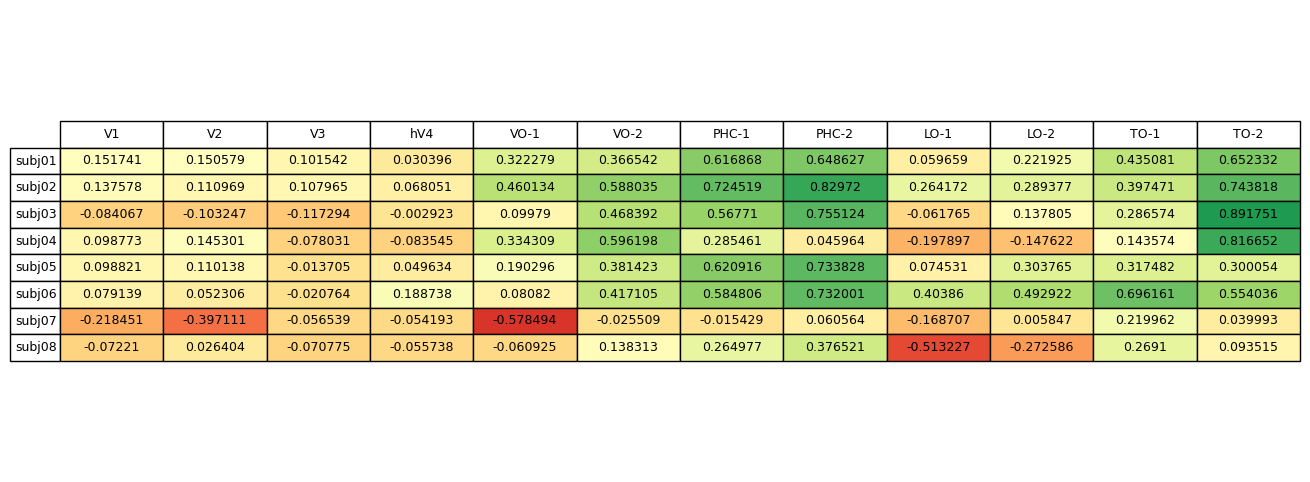

In [124]:
df = voxel_perf_per_voxel.apply(pd.to_numeric)
norm = plt.Normalize(df.values.min()-0.2, df.values.max()+0.2)

# Create a custom colormap
cmap = plt.get_cmap('RdYlGn')

# Create a figure and a single subplot
fig, ax = plt.subplots(figsize=(10, 6))

# Hide the axes
ax.axis('tight')
ax.axis('off')

# Create a table with colored cells
cell_colors = cmap(norm(df.values))

# Add table to the axes
table = ax.table(cellText=df.values.round(6),
                 rowLabels=df.index,
                 colLabels=df.columns,
                 cellColours=cell_colors,
                 cellLoc='center',
                 loc='center')

# Customize the table appearance
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1.6, 1.6)
plt.savefig('voxel_perf_best_roi.png', bbox_inches='tight')
# Display the plotSS
plt.show()

In [130]:
VE_per_voxel = pd.DataFrame( index=subj_list, columns=list(rois.keys()) )
                                    
for i, subj in enumerate(subj_list):
    if subj == 'subj06' or subj == 'subj08':
        roi_mask = os.path.join(mask_dir, subj, f'short.reduced.nans.{subj}.testrois.npy')
    else:
        roi_mask = os.path.join(mask_dir, subj, f'short.reduced.{subj}.testrois.npy')
    mask = np.load(roi_mask).astype(int)
    VE_per_voxel.iloc[i] = models_subs[subj]['oself']['test_var_explained'].groupby(mask).mean()
noise_ceilling_per_voxel

,V1,V2,V3,hV4,VO-1,VO-2,PHC-1,PHC-2,LO-1,LO-2,TO-1,TO-2
subj01,0.160141,0.149004,0.121824,0.089139,0.089698,0.085216,0.081076,0.089601,0.063419,0.072624,0.186105,0.143335
subj02,0.207029,0.13017,0.135489,0.151028,0.120554,0.101368,0.095674,0.106872,0.091456,0.095145,0.154912,0.118954
subj03,0.092003,0.074787,0.051863,0.046266,0.065372,0.059983,0.064044,0.094903,0.029901,0.042929,0.122582,0.075624
subj04,0.099694,0.101062,0.052432,0.044738,0.071621,0.061387,0.069915,0.077274,0.022318,0.052382,0.057126,0.132277
subj05,0.121639,0.113051,0.08204,0.092427,0.110654,0.093609,0.118989,0.153154,0.06393,0.114499,0.131577,0.159661
subj06,0.103976,0.094369,0.062552,0.051291,0.06783,0.079387,0.085221,0.100913,0.027471,0.072598,0.100141,0.047992
subj07,0.053931,0.048471,0.043206,0.035782,0.059047,0.036257,0.02264,0.033077,0.020985,0.064429,0.068251,0.087659
subj08,0.061587,0.058725,0.039229,0.051098,0.045447,0.038712,0.045437,0.045775,0.024054,0.034068,0.036513,0.033981


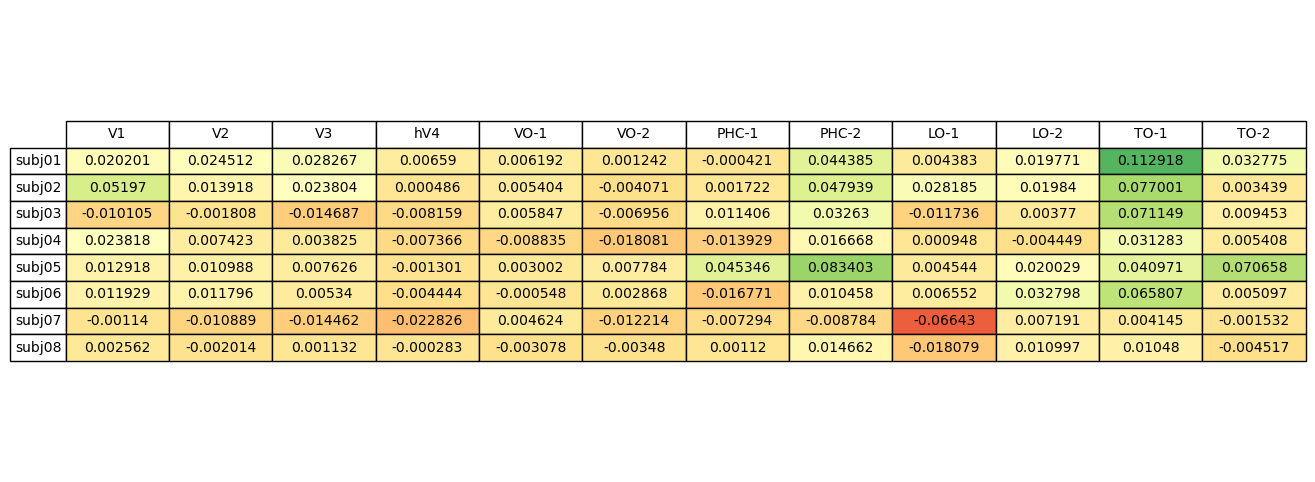

In [131]:
df = VE_per_voxel.apply(pd.to_numeric)
norm = plt.Normalize(df.values.min()-0.05, df.values.max()+0.05)

# Create a custom colormap
cmap = plt.get_cmap('RdYlGn')

# Create a figure and a single subplot
fig, ax = plt.subplots(figsize=(10, 6))

# Hide the axes
ax.axis('tight')
ax.axis('off')

# Create a table with colored cells
cell_colors = cmap(norm(df.values))

# Add table to the axes
table = ax.table(cellText=df.values.round(6),
                 rowLabels=df.index,
                 colLabels=df.columns,
                 cellColours=cell_colors,
                 cellLoc='center',
                 loc='center')

# Customize the table appearance
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.6, 1.6)
plt.savefig('VE_oself.png', bbox_inches='tight')
# Display the plotSS
plt.show()

In [132]:
noise_ceilling_per_voxel = pd.DataFrame( index=subj_list, columns=list(rois.keys()) )
                                    
for i, subj in enumerate(subj_list):
    if subj == 'subj06' or subj == 'subj08':
        roi_mask = os.path.join(mask_dir, subj, f'short.reduced.nans.{subj}.testrois.npy')
    else:
        roi_mask = os.path.join(mask_dir, subj, f'short.reduced.{subj}.testrois.npy')
    mask = np.load(roi_mask).astype(int)
    noise_ceilling_per_voxel.iloc[i] = models_subs[subj]['oself']['noise_ceilling'].groupby(mask).mean()
noise_ceilling_per_voxel

,V1,V2,V3,hV4,VO-1,VO-2,PHC-1,PHC-2,LO-1,LO-2,TO-1,TO-2
subj01,0.160141,0.149004,0.121824,0.089139,0.089698,0.085216,0.081076,0.089601,0.063419,0.072624,0.186105,0.143335
subj02,0.207029,0.13017,0.135489,0.151028,0.120554,0.101368,0.095674,0.106872,0.091456,0.095145,0.154912,0.118954
subj03,0.092003,0.074787,0.051863,0.046266,0.065372,0.059983,0.064044,0.094903,0.029901,0.042929,0.122582,0.075624
subj04,0.099694,0.101062,0.052432,0.044738,0.071621,0.061387,0.069915,0.077274,0.022318,0.052382,0.057126,0.132277
subj05,0.121639,0.113051,0.08204,0.092427,0.110654,0.093609,0.118989,0.153154,0.06393,0.114499,0.131577,0.159661
subj06,0.103976,0.094369,0.062552,0.051291,0.06783,0.079387,0.085221,0.100913,0.027471,0.072598,0.100141,0.047992
subj07,0.053931,0.048471,0.043206,0.035782,0.059047,0.036257,0.02264,0.033077,0.020985,0.064429,0.068251,0.087659
subj08,0.061587,0.058725,0.039229,0.051098,0.045447,0.038712,0.045437,0.045775,0.024054,0.034068,0.036513,0.033981


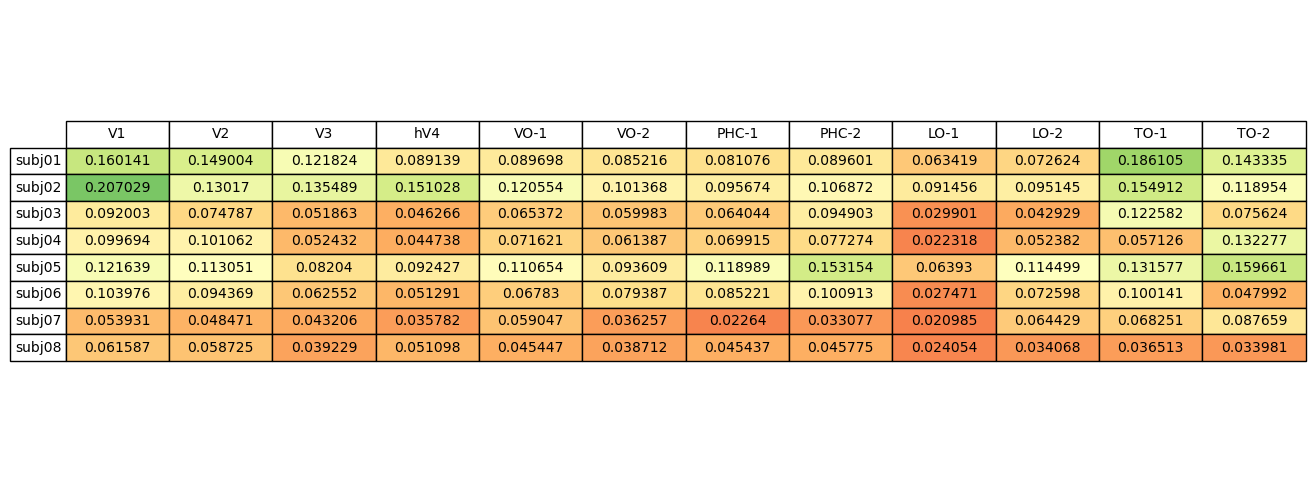

In [133]:
df = noise_ceilling_per_voxel.apply(pd.to_numeric)
norm = plt.Normalize(df.values.min()-0.08, df.values.max()+0.08)

# Create a custom colormap
cmap = plt.get_cmap('RdYlGn')

# Create a figure and a single subplot
fig, ax = plt.subplots(figsize=(10, 6))

# Hide the axes
ax.axis('tight')
ax.axis('off')

# Create a table with colored cells
cell_colors = cmap(norm(df.values))

# Add table to the axes
table = ax.table(cellText=df.values.round(6),
                 rowLabels=df.index,
                 colLabels=df.columns,
                 cellColours=cell_colors,
                 cellLoc='center',
                 loc='center')

# Customize the table appearance
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.6, 1.6)
plt.savefig('noise_ceilling_oself.png', bbox_inches='tight')
# Display the plotSS
plt.show()

In [134]:
voxel_perf_per_voxel = pd.DataFrame( index=subj_list, columns=list(rois.keys()) )
                                    
for i, subj in enumerate(subj_list):
    if subj == 'subj06' or subj == 'subj08':
        roi_mask = os.path.join(mask_dir, subj, f'short.reduced.nans.{subj}.testrois.npy')
    else:
        roi_mask = os.path.join(mask_dir, subj, f'short.reduced.{subj}.testrois.npy')
    mask = np.load(roi_mask).astype(int)
    voxel_perf_per_voxel.iloc[i] = models_subs[subj]['oself']['voxel_performance'].groupby(mask).median()
voxel_perf_per_voxel

,V1,V2,V3,hV4,VO-1,VO-2,PHC-1,PHC-2,LO-1,LO-2,TO-1,TO-2
subj01,0.040025,0.12344,0.170305,0.042499,0.019779,-0.006485,-0.012187,0.551065,0.00959,0.196468,0.654974,0.256429
subj02,0.169498,0.024915,0.100674,-0.015865,0.018734,-0.039091,0.006008,0.519051,0.175942,0.175634,0.560543,-0.009759
subj03,-0.156835,-0.044242,-0.305162,-0.183178,0.044949,-0.128011,0.197814,0.387031,-0.321619,0.006857,0.477796,0.110832
subj04,0.118806,0.021032,-0.008325,-0.255032,-0.153751,-0.289939,-0.232878,-0.035614,-0.188762,-0.165723,0.541446,-0.036305
subj05,0.008787,0.046391,0.016487,-0.047193,-0.046799,0.061238,0.371224,0.580817,-0.081235,0.095299,0.341767,0.31094
subj06,0.049803,0.069936,0.039297,-0.087255,-0.01695,0.010565,-0.175242,0.055851,0.048446,0.436096,0.752979,-0.002285
subj07,-0.064616,-0.32504,-0.689098,-1.093173,0.017325,-0.364204,-0.078304,-0.164701,-3.85799,-0.020043,0.026926,-0.018189
subj08,-0.023141,-0.041292,-0.038437,-0.034179,-0.096871,-0.166312,-0.027234,0.295557,-1.019041,-0.042964,0.25848,-0.241625


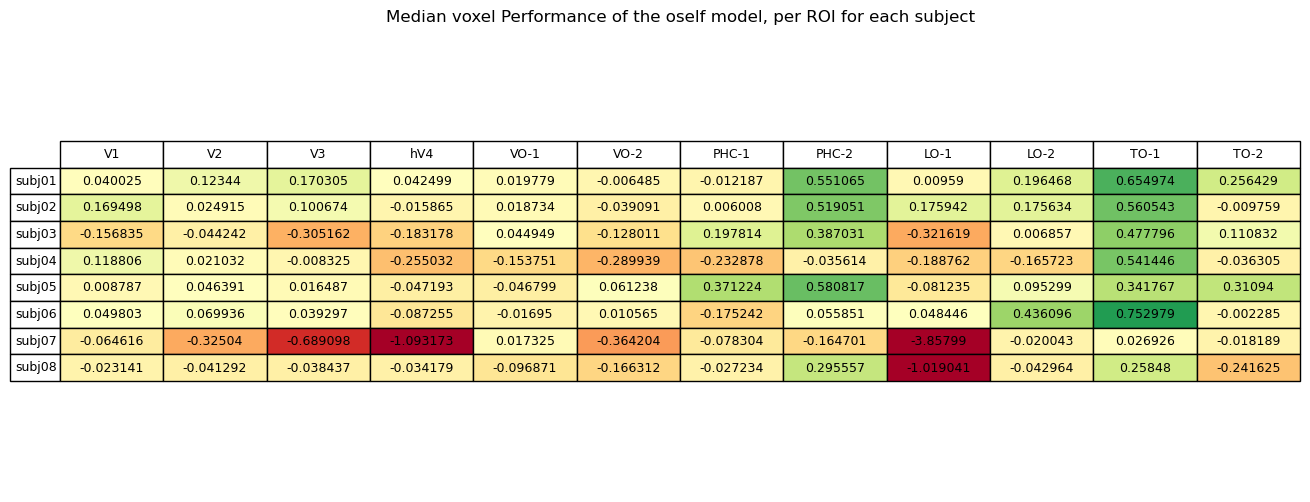

In [141]:
df = voxel_perf_per_voxel.apply(pd.to_numeric)
norm = plt.Normalize(df.values.min()+3, df.values.max()+0.2)

# Create a custom colormap
cmap = plt.get_cmap('RdYlGn')

# Create a figure and a single subplot
fig, ax = plt.subplots(figsize=(10, 6))

# Hide the axes
ax.axis('tight')
ax.axis('off')

# Create a table with colored cells
cell_colors = cmap(norm(df.values))

# Add table to the axes
table = ax.table(cellText=df.values.round(6),
                 rowLabels=df.index,
                 colLabels=df.columns,
                 cellColours=cell_colors,
                 cellLoc='center',
                 loc='center')

# Customize the table appearance
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1.6, 1.6)
plt.title('Median voxel Performance of the oself model, per ROI for each subject') 
plt.savefig('voxel_perf_oself.png', bbox_inches='tight')
# Display the plotSS
plt.show()

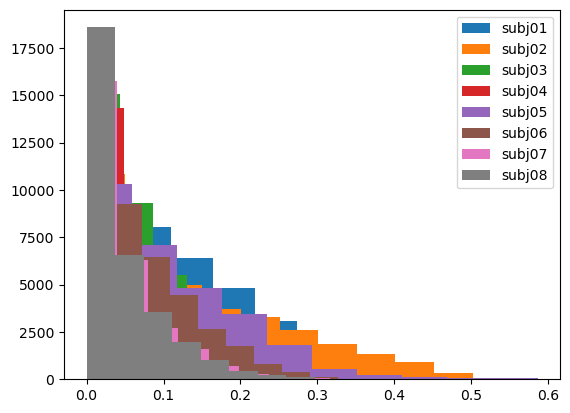

In [61]:
for i, sub in enumerate(subj_list):
    noise_ceilling_file = os.path.join(noise_dir, f'{sub}_noise_ceilling_all_vox.npy')
    noise_ceilling = np.load(noise_ceilling_file, allow_pickle=True)
    plt.hist(noise_ceilling)
plt.legend(subj_list)
plt.show()

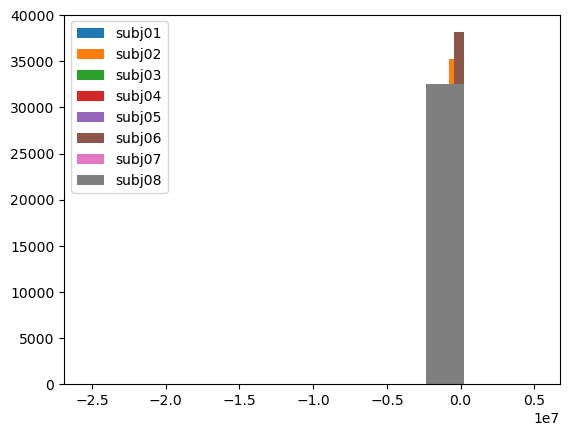

In [6]:
for i, sub in enumerate(subj_list):
    plt.hist(models_subs[sub]["best_roi"]["voxel_performance"])
plt.legend(subj_list)
plt.show()

In [93]:
colors = sns.color_palette('hls', 12)
for r in rois.keys():
    c = colors[list(rois.keys()).index(r)]

In [96]:
colors

[(0.86, 0.3712, 0.33999999999999997),
 (0.86, 0.6312, 0.33999999999999997),
 (0.8287999999999999, 0.86, 0.33999999999999997),
 (0.5688000000000001, 0.86, 0.33999999999999997),
 (0.33999999999999997, 0.86, 0.3712),
 (0.33999999999999997, 0.86, 0.6312),
 (0.33999999999999997, 0.8287999999999999, 0.86),
 (0.33999999999999997, 0.5688000000000001, 0.86),
 (0.3712, 0.33999999999999997, 0.86),
 (0.6311999999999998, 0.33999999999999997, 0.86),
 (0.86, 0.33999999999999997, 0.8287999999999999),
 (0.86, 0.33999999999999997, 0.5688000000000001)]

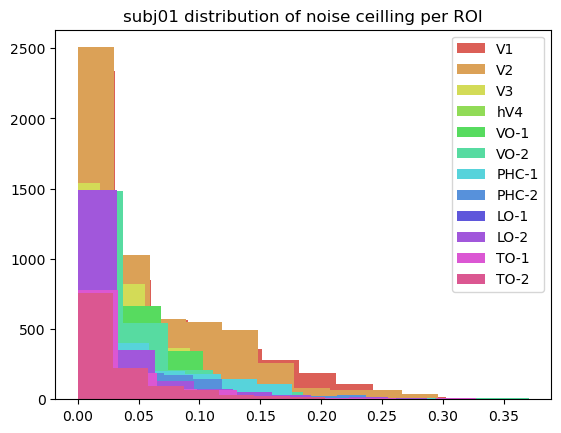

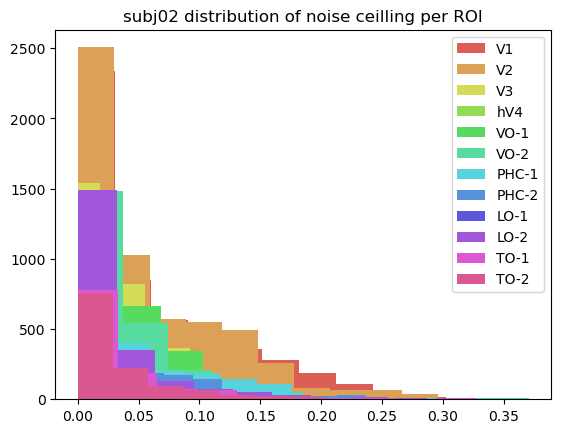

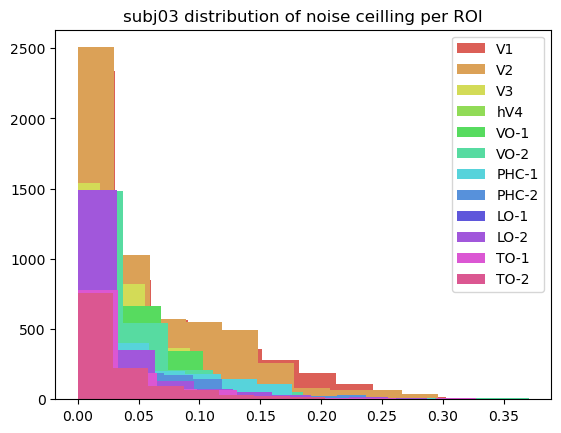

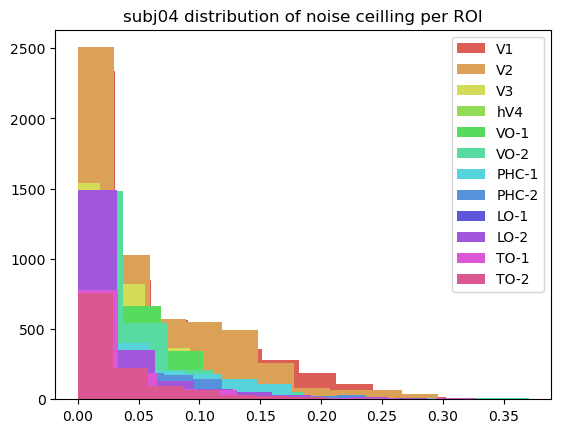

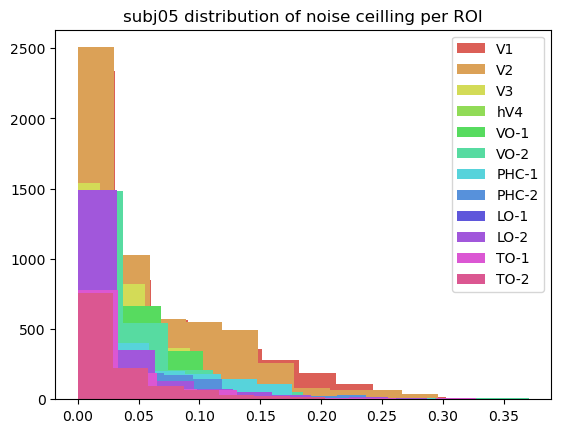

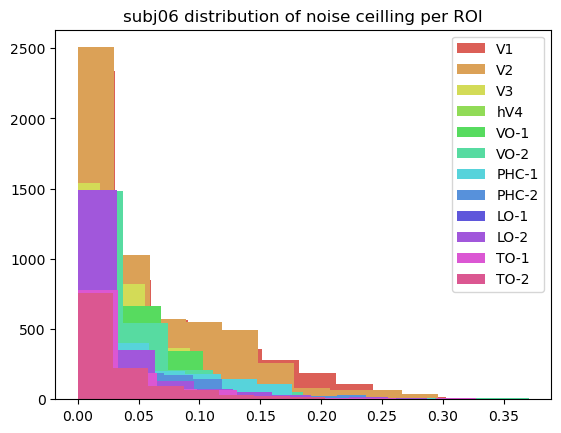

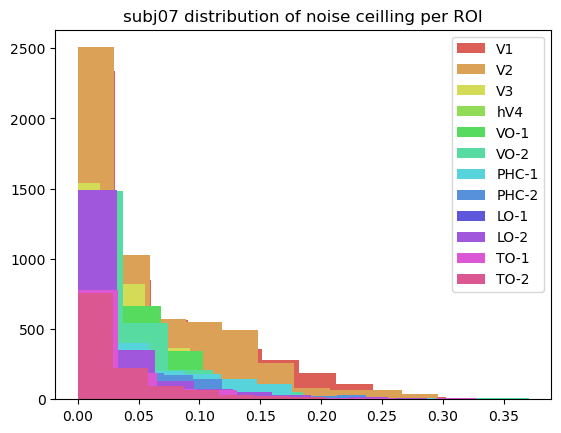

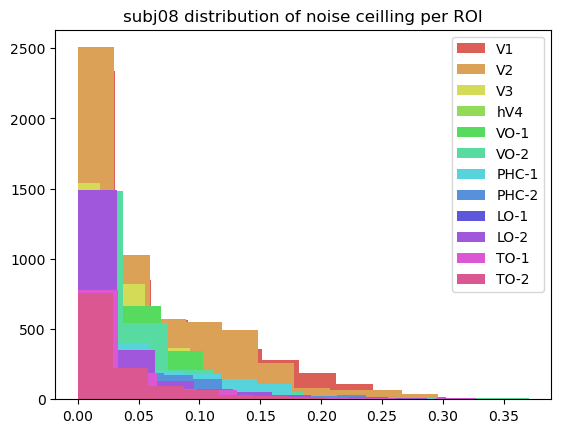

In [98]:



for i, subj in enumerate(subj_list):
    for j, roi in enumerate(rois.keys()):
        plt.hist(models_subs[sub]["best_roi"]["noise_ceilling"][mask == j+1], color=colors[j])
    plt.title(f'{subj} distribution of noise ceilling per ROI')
    plt.legend(rois.keys())
    plt.show()

In [102]:
models_subs[sub]["best_roi"]

,x0,y0,sigma,slope,intercept,test_var_explained,var_explained,mds_ecc,mds_ang,roi,best_roi,noise_ceilling,R2,voxel_performance
0,0.250348,1.050000,2.976745,5.628830,-5.455821,-0.000824,0.011913,1.079432,0.234057,V2,V3,0.014468,0.985532,-0.056927
1,-0.200695,-1.050000,2.980398,6.046176,-5.873450,-0.003880,0.010394,1.069008,-2.952732,V2,V3,0.013273,0.986727,-0.292343
2,-0.340419,-1.050000,3.561589,6.755182,-6.599545,-0.005201,0.012681,1.103805,-2.828076,V2,V3,0.002603,0.997397,-1.000000
3,0.228940,1.050000,4.942216,14.769474,-14.613513,0.000092,0.010350,1.074669,0.214678,V2,V3,0.005717,0.994283,0.016150
4,-0.231625,-1.050000,2.690522,5.319668,-5.129147,-0.003727,0.014244,1.075244,-2.924475,V2,V3,0.010765,0.989235,-0.346227
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32531,-1.050000,0.559712,0.880034,0.655219,-0.300897,0.029911,0.046248,1.197904,-1.081053,PHC-2,TO-1,0.009360,0.990640,1.000000
32532,-1.050000,0.550310,0.787731,0.554011,-0.221717,0.025934,0.035350,1.197904,-1.088051,PHC-2,TO-1,0.006335,0.993665,1.000000
32533,-1.050000,0.872429,0.648672,0.333299,-0.093137,0.005832,0.011863,1.197904,-0.877505,PHC-2,TO-1,0.001504,0.998496,1.000000
32534,0.178514,-1.038981,0.112618,0.314026,0.003198,-0.002668,0.001083,0.603606,2.971438,PHC-2,TO-1,0.005262,0.994738,-0.507036


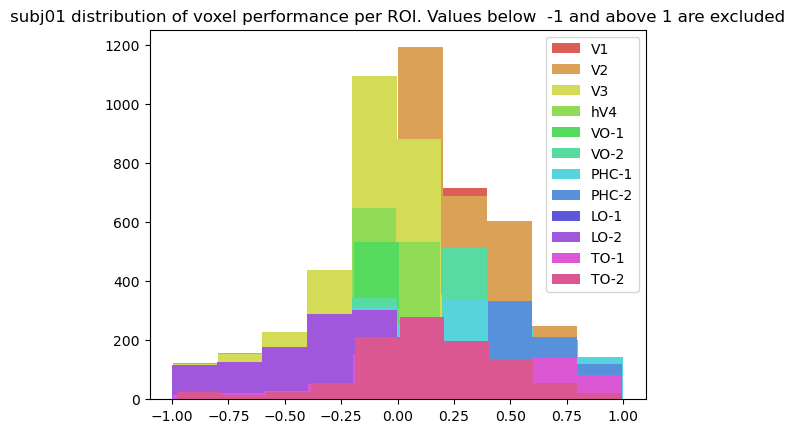

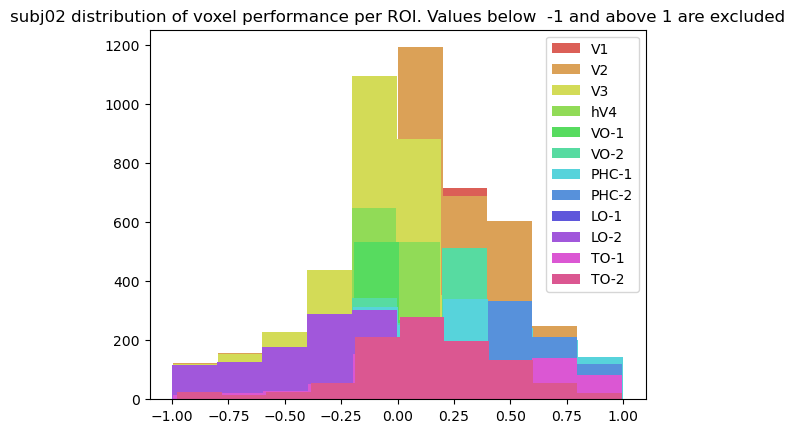

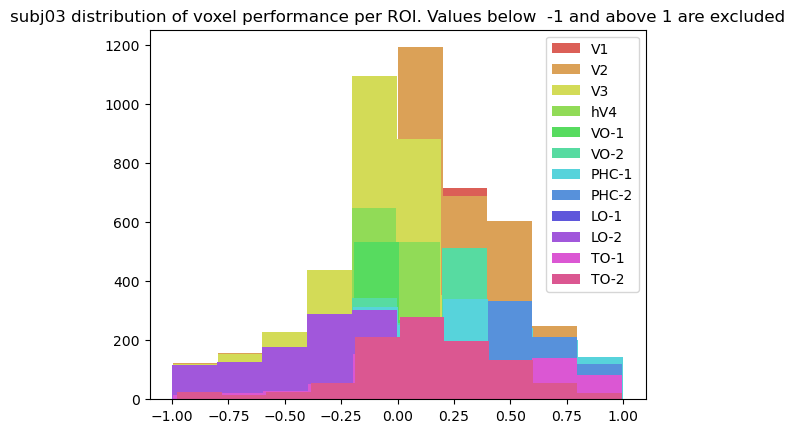

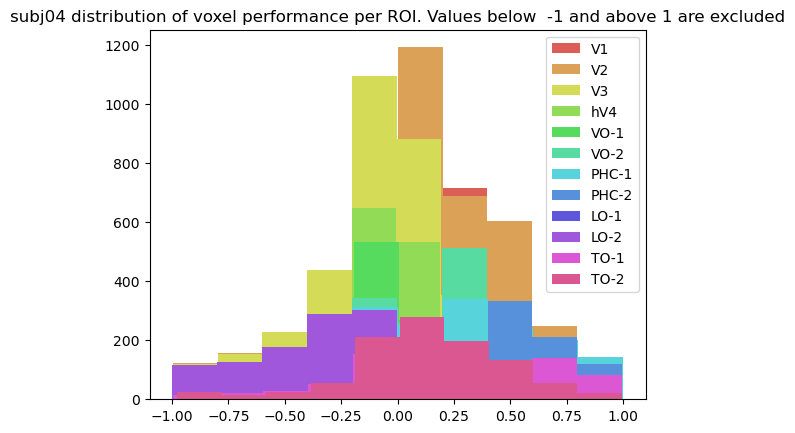

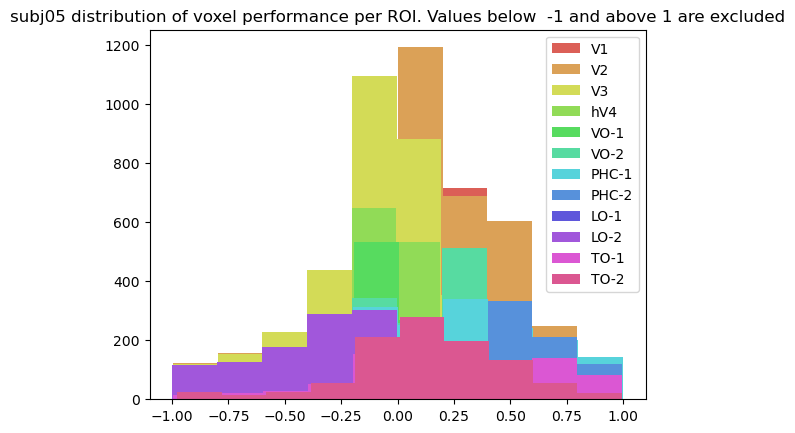

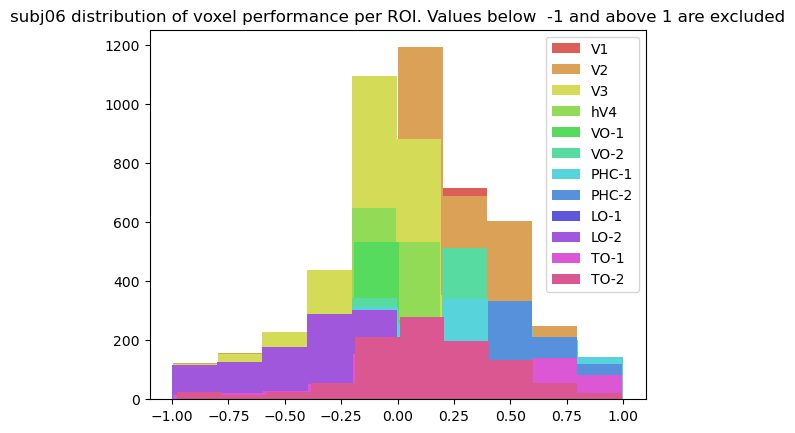

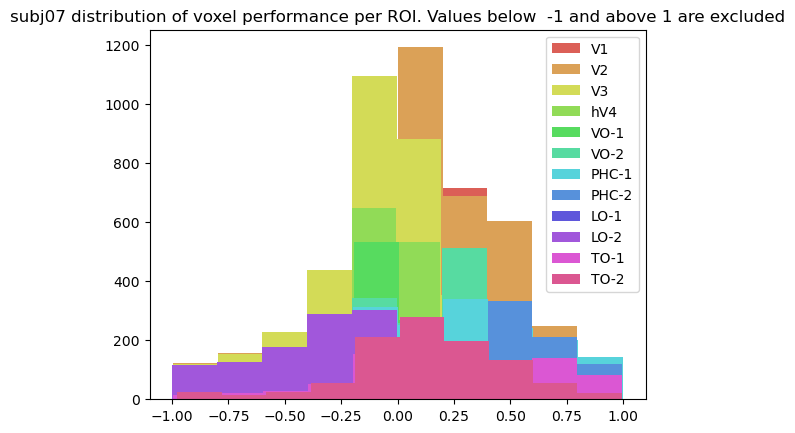

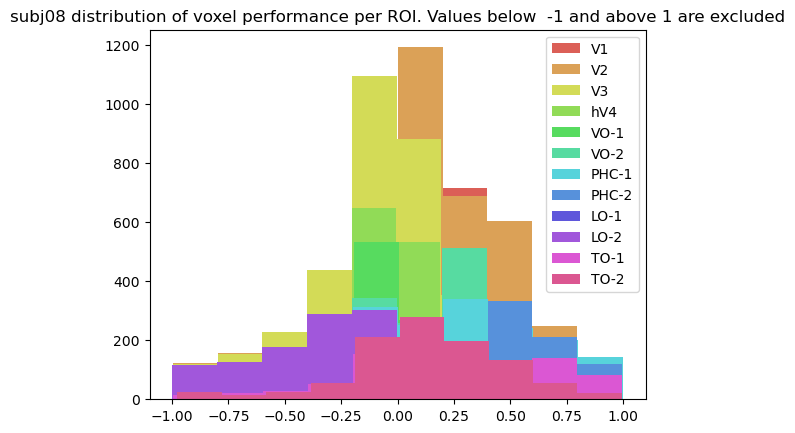

In [113]:
for i, subj in enumerate(subj_list):
    for j, roi in enumerate(rois.keys()):
    #    models_subs[sub]["best_roi"].loc[models_subs[sub]["best_roi"]["voxel_performance"] > 1] = 1 
      #  models_subs[sub]["best_roi"].loc[models_subs[sub]["best_roi"]["voxel_performance"] < -1] = -1 
        
        plt.hist(models_subs[sub]["best_roi"]["voxel_performance"][mask == j+1]\
                 [(models_subs[sub]["best_roi"]["voxel_performance"][mask == j+1] > -1) & \
                 (models_subs[sub]["best_roi"]["voxel_performance"][mask == j+1] < 1)] , color=colors[j])
 # plt.xlim(left=-1)
  #  plt.xlim(right=1)
    plt.title(f'{subj} distribution of voxel performance per ROI. Values below  -1 and above 1 are excluded')
    plt.legend(rois.keys())
    plt.show()

In [44]:
max(models_subs[sub]["best_roi"]["voxel_performance"][models_subs[sub]["best_roi"]["voxel_performance"] > 1] )

232634.6606879653

In [29]:
noise_ceilling_per_voxel = pd.DataFrame( index=subj_list, columns=list(rois.keys()) )
                                    
for i, subj in enumerate(subj_list):
    if subj == 'subj06' or subj == 'subj08':
        roi_mask = os.path.join(mask_dir, subj, f'short.reduced.nans.{subj}.testrois.npy')
    else:
        roi_mask = os.path.join(mask_dir, subj, f'short.reduced.{subj}.testrois.npy')
    mask = np.load(roi_mask).astype(int)
    noise_ceilling_per_voxel.iloc[i] = models_subs[subj]['best_roi']['R2'].groupby(mask).mean()
noise_ceilling_per_voxel

,V1,V2,V3,hV4,VO-1,VO-2,PHC-1,PHC-2,LO-1,LO-2,TO-1,TO-2
subj01,0.839859,0.850996,0.878176,0.910861,0.910302,0.914784,0.918924,0.910399,0.936581,0.927376,0.813895,0.856665
subj02,0.792971,0.86983,0.864511,0.848972,0.879446,0.898632,0.904326,0.893128,0.908544,0.904855,0.845088,0.881046
subj03,0.907997,0.925213,0.948137,0.953734,0.934628,0.940017,0.935956,0.905097,0.970099,0.957071,0.877418,0.924376
subj04,0.900306,0.898938,0.947568,0.955262,0.928379,0.938613,0.930085,0.922726,0.977682,0.947618,0.942874,0.867723
subj05,0.878361,0.886949,0.91796,0.907573,0.889346,0.906391,0.881011,0.846846,0.93607,0.885501,0.868423,0.840339
subj06,0.896024,0.905631,0.937448,0.948709,0.93217,0.920613,0.914779,0.899087,0.972529,0.927402,0.899859,0.952008
subj07,0.946069,0.951529,0.956794,0.964218,0.940953,0.963743,0.97736,0.966923,0.979015,0.935571,0.931749,0.912341
subj08,0.938413,0.941275,0.960771,0.948902,0.954553,0.961288,0.954563,0.954225,0.975946,0.965932,0.963487,0.966019


## R2

In [76]:
models_subs = {}
models = ['oself']
columns = ["x0", "y0", "sigma", "slope", "intercept", "test_var_explained", "var_explained", "mds_ecc", "mds_ang", "roi", "fit_with"]
model_study = 'oself'
mode = "train"
rotated = True

for i, sub in enumerate(subj_list):
    models_subs[sub] = {}
    for m in models:
        if rotated:
            m_file = os.path.join(models_dir, f'best_fits_{m}_{sub}_{mode}_basevoxel_rotated.npy')
        models_subs[sub][m] = pd.DataFrame(np.load(m_file, allow_pickle=True), columns=columns)
        models_subs[sub][m][columns[:-2]] = models_subs[sub][m][columns[:-2]].astype(np.float32)
        
variance = np.zeros((len(subj_list), len(rois.keys())))
m = models[0]
for i, sub in enumerate(subj_list):
    for j, roi in enumerate(rois.keys()):
        variance[i, j] = models_subs[sub][m].groupby('roi')['test_var_explained'].mean()[roi]

var_df = pd.DataFrame(variance, index=subj_list, columns=rois.keys())
var_df

,V1,V2,V3,hV4,VO-1,VO-2,PHC-1,PHC-2,LO-1,LO-2,TO-1,TO-2
subj01,0.020127,0.024559,0.027996,0.006702,0.006120,0.001188,-0.000497,0.046580,0.004290,0.019371,0.111311,0.032075
subj02,0.052120,0.013884,0.023750,0.000542,0.005357,-0.004125,0.001707,0.046504,0.028635,0.019667,0.077120,0.003169
subj03,-0.009582,-0.001906,-0.014460,-0.008087,0.005737,-0.007017,0.011596,0.033603,-0.011710,0.003969,0.070339,0.010125
subj04,0.023780,0.007202,0.004065,-0.007424,-0.009167,-0.018012,-0.013945,0.017712,0.000777,-0.004043,0.031522,0.005109
subj05,0.013025,0.010748,0.007668,-0.001056,0.002531,0.007741,0.045138,0.083541,0.004914,0.021058,0.041287,0.071646
subj06,0.012192,0.011738,0.005183,-0.004300,-0.000517,0.003039,-0.016918,0.010041,0.006544,0.033192,0.066874,0.005053
subj07,-0.001341,-0.010841,-0.014084,-0.022722,0.004575,-0.011937,-0.007484,-0.008730,-0.065581,0.007143,0.003994,-0.001561
subj08,0.002348,-0.002088,0.001091,-0.000202,-0.003080,-0.003358,0.001176,0.014636,-0.018498,0.011219,0.009713,-0.004543


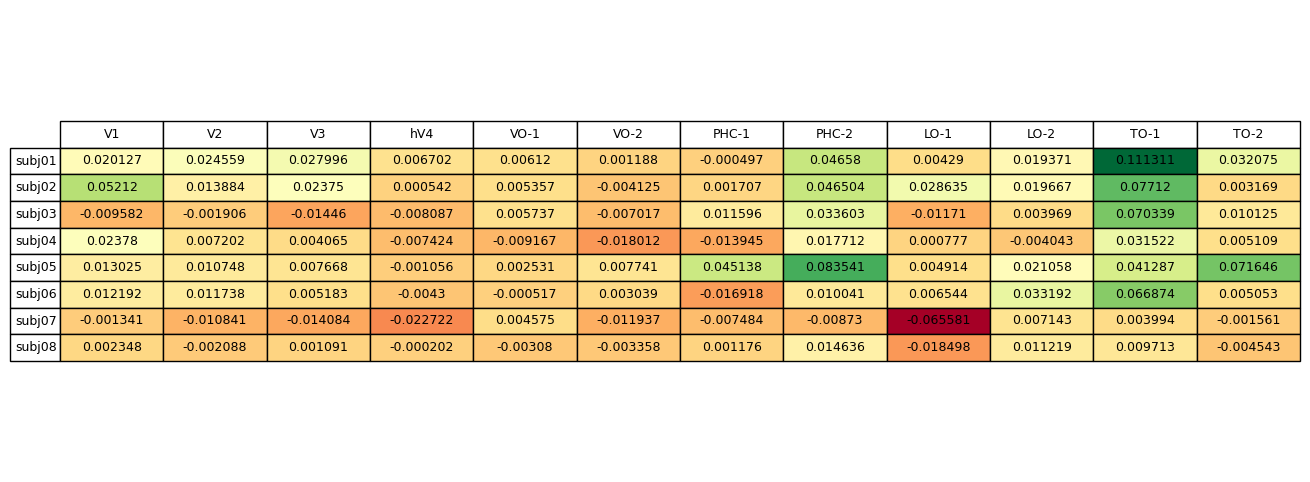

In [79]:
df = var_df.apply(pd.to_numeric)
norm = plt.Normalize(df.values.min(), df.values.max())

# Create a custom colormap
cmap = plt.get_cmap('RdYlGn')

# Create a figure and a single subplot
fig, ax = plt.subplots(figsize=(10, 6))

# Hide the axes
ax.axis('tight')
ax.axis('off')

# Create a table with colored cells
cell_colors = cmap(norm(df.values))

# Add table to the axes
table = ax.table(cellText=df.values.round(6),
                 rowLabels=df.index,
                 colLabels=df.columns,
                 cellColours=cell_colors,
                 cellLoc='center',
                 loc='center')

# Customize the table appearance
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1.6, 1.6)

# Display the plotSS
plt.show()

In [ ]:
#thats cool: the model is doing really good on to1

In [416]:
percentage_variance_df = (var_df/best_variance_df) * 100
percentage_variance_df

,V1,V2,V3,hV4,VO-1,VO-2,PHC-1,PHC-2,LO-1,LO-2,TO-1,TO-2
subj01,12.575630,16.455001,22.874295,7.400126,6.757456,1.383191,-0.607460,52.012219,6.641929,26.445126,59.844541,22.420648
subj02,25.177067,10.636021,17.442643,0.357286,4.432530,-4.044698,1.769543,43.356258,31.062151,20.566611,49.827340,2.667423
subj03,-10.404860,-2.550768,-27.850923,-17.372535,8.745694,-11.654046,18.128655,35.625614,-38.908203,9.191103,57.510828,13.445272
subj04,23.768436,7.095939,7.703299,-16.344273,-12.653167,-28.899144,-19.605154,22.440742,3.385954,-7.542614,53.703819,3.932575
subj05,10.731322,9.551751,9.341579,-1.140946,2.266332,8.198027,37.849206,54.615128,7.660826,18.419759,31.427921,45.247634
subj06,11.713332,12.442999,8.297795,-8.377600,-0.761948,3.816321,-19.786955,9.927293,23.742311,45.763992,66.978818,10.661310
subj07,-2.485297,-22.313975,-32.538502,-63.543225,7.723657,-32.845839,-33.009039,-26.384688,-311.699890,11.075245,5.844444,-1.780263
subj08,3.779843,-3.533433,2.757872,-0.392561,-6.769628,-8.638650,2.590087,31.964741,-76.326851,32.817213,26.670868,-13.376876
